In [1]:

import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_22.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_53.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_37.png
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_69.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_68.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_51.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_75.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_12.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_16.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_72.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_58.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_62.jpg
/kaggle/input/dangerous-insects-dataset/

Found 1591 files belonging to 15 classes.
Using 1273 files for training.
Found 1591 files belonging to 15 classes.
Using 318 files for validation.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.1400 - loss: 56.6284 - val_accuracy: 0.3648 - val_loss: 21.6346
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.4260 - loss: 20.6689 - val_accuracy: 0.6164 - val_loss: 9.5932
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.6152 - loss: 10.5256 - val_accuracy: 0.7075 - val_loss: 8.8378
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.6639 - loss: 7.9946 - val_accuracy: 0.7547 - val_loss: 6.1759
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.7396 - loss: 6.6134 - val_accuracy: 0.7201 - val_loss: 8.6403
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7482 - loss: 6.7582 - val_accuracy: 0.8396 - val_loss: 5.6312
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━

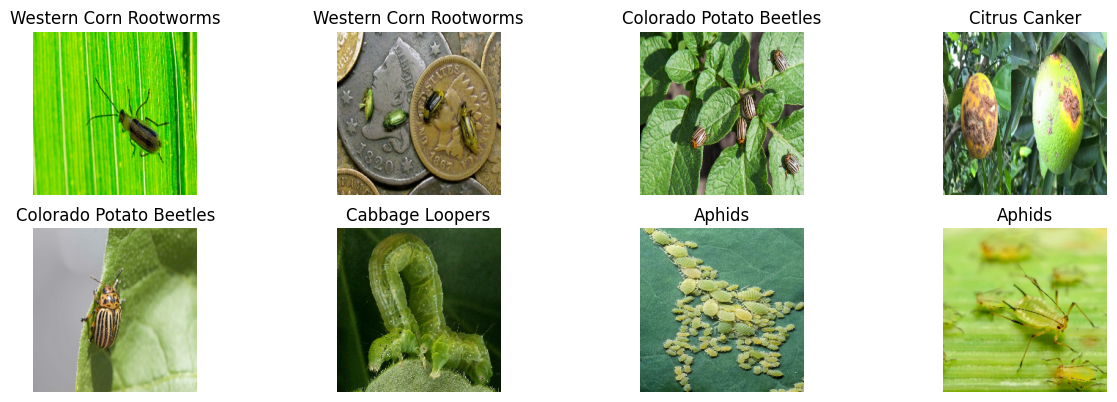

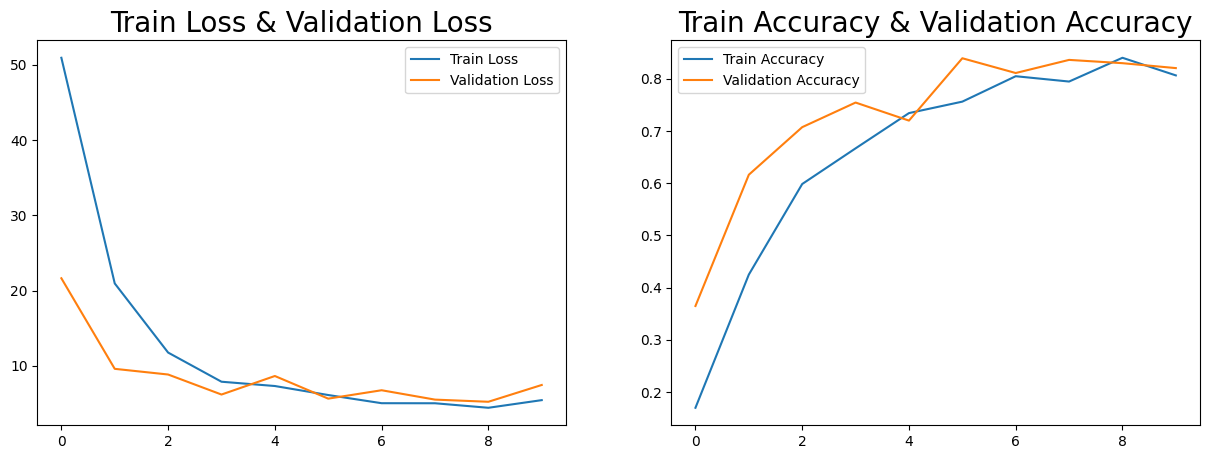

10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step


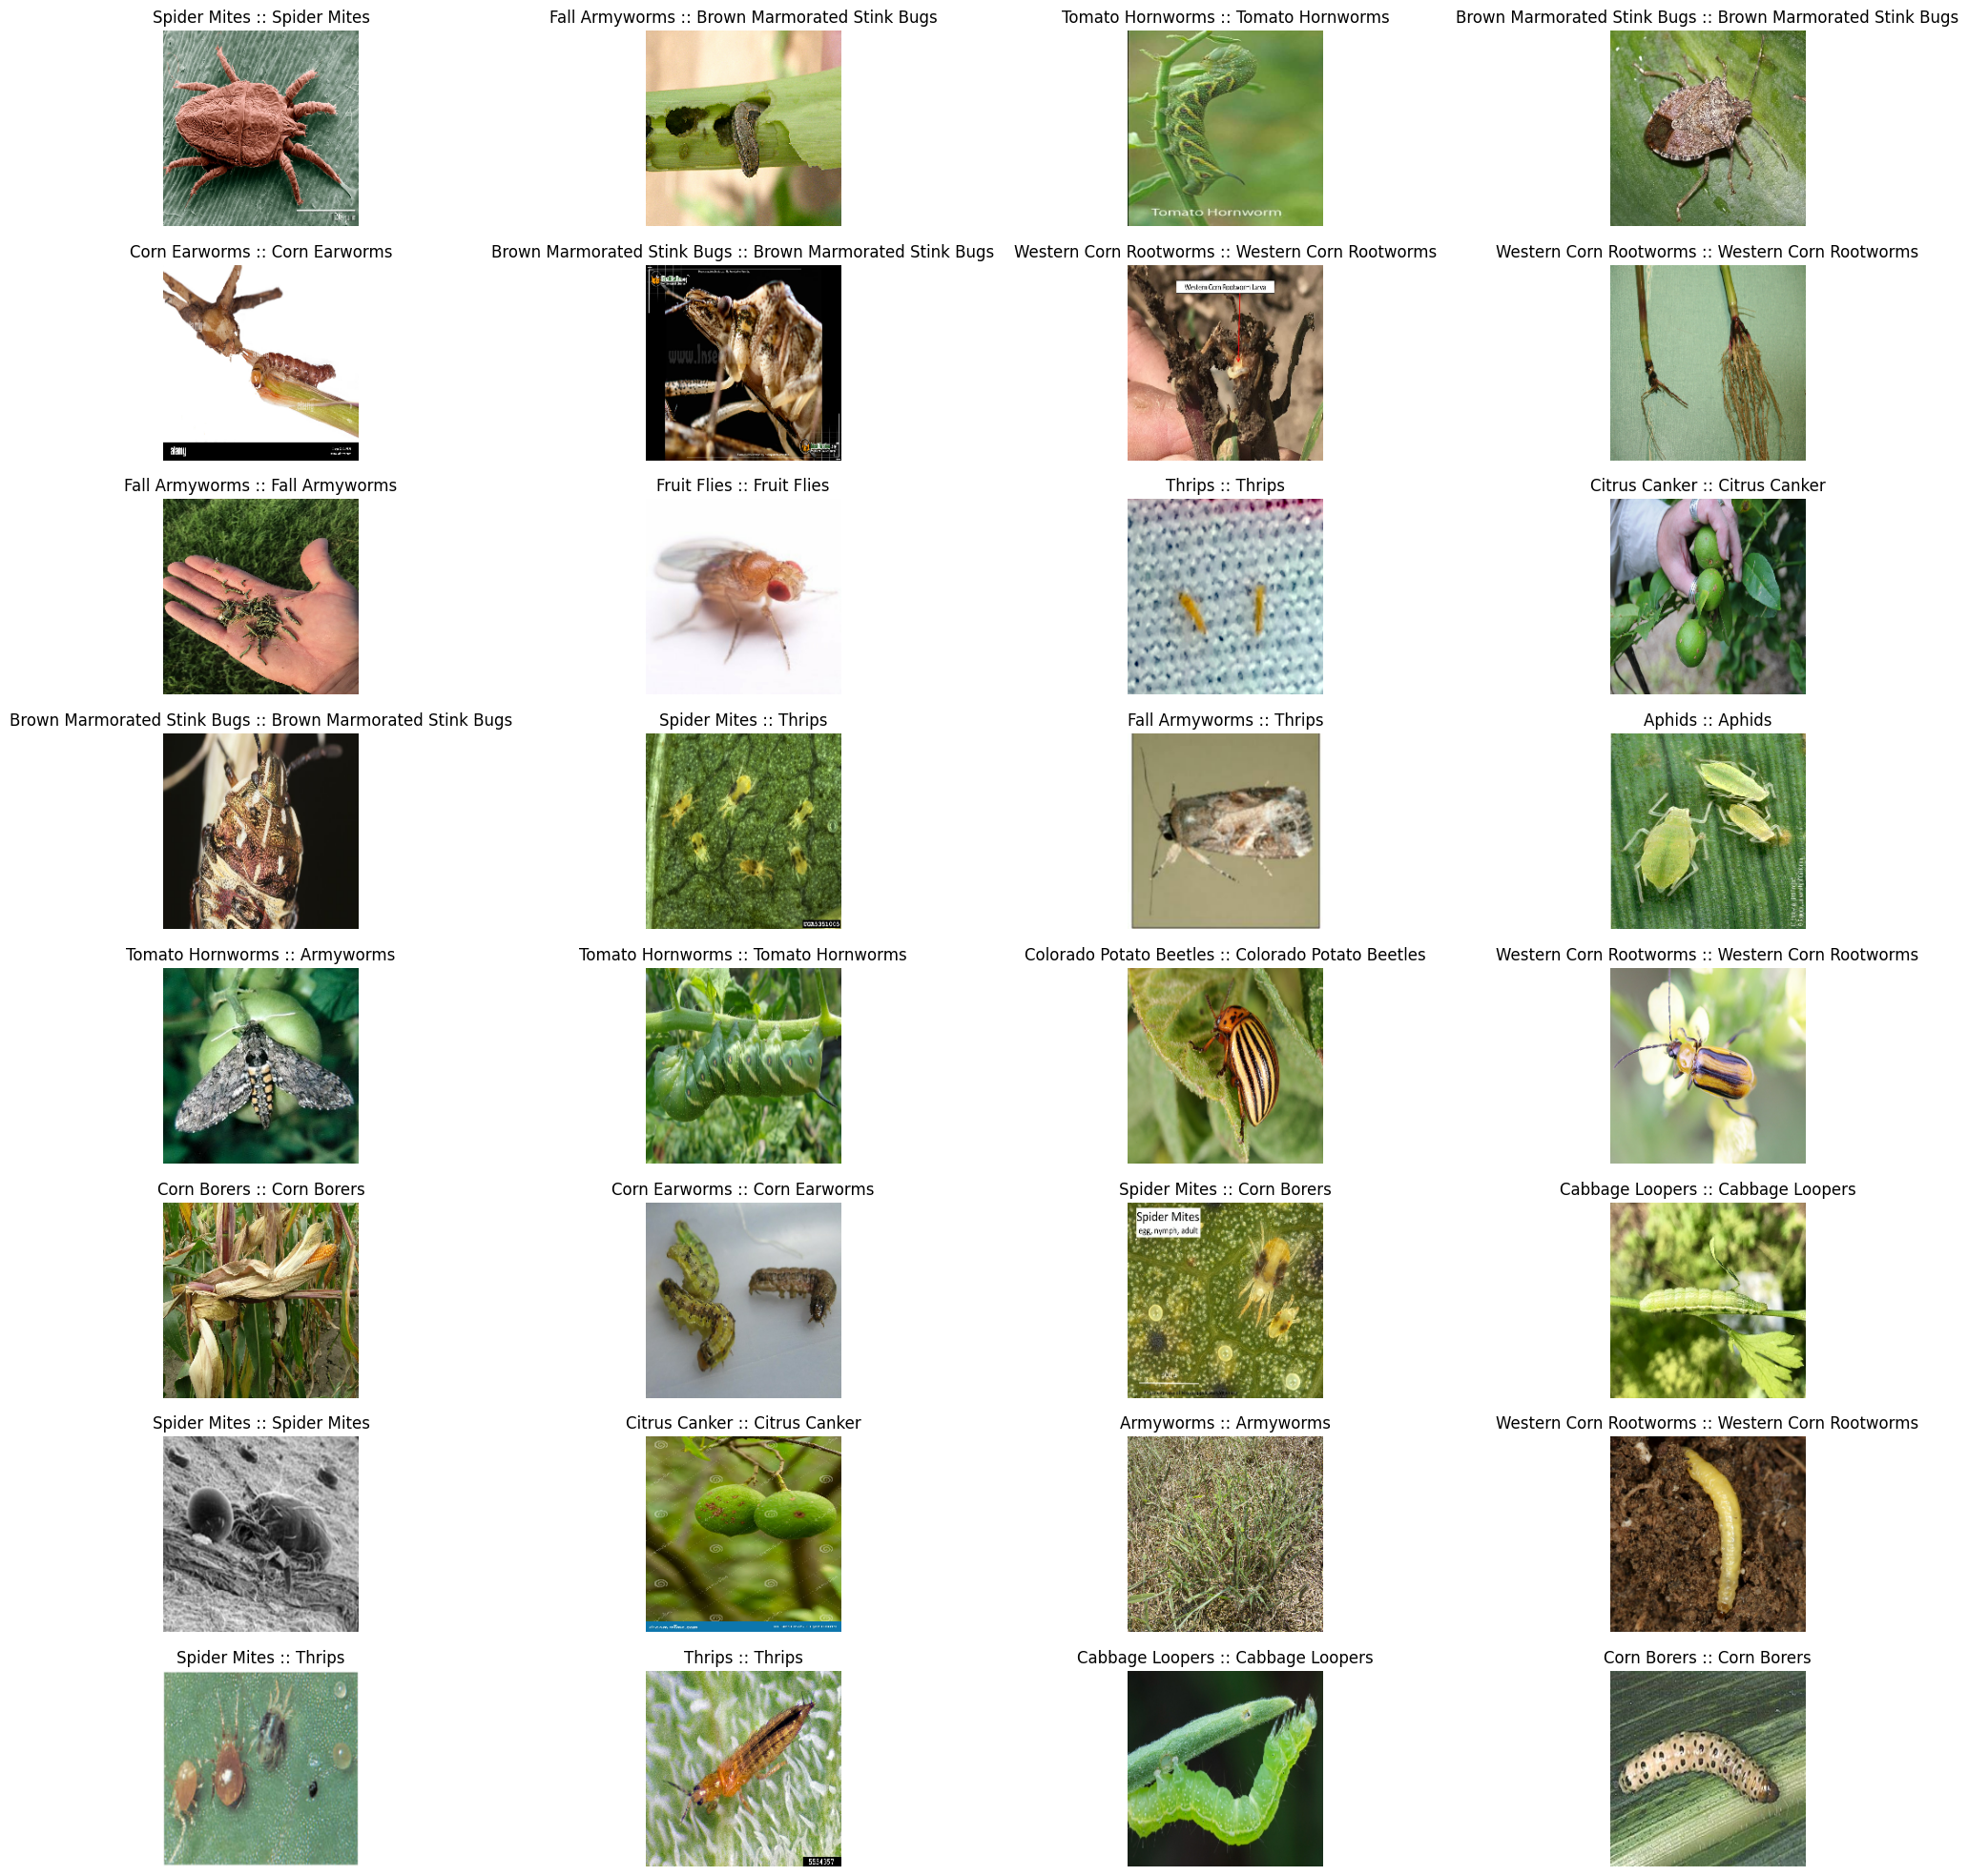

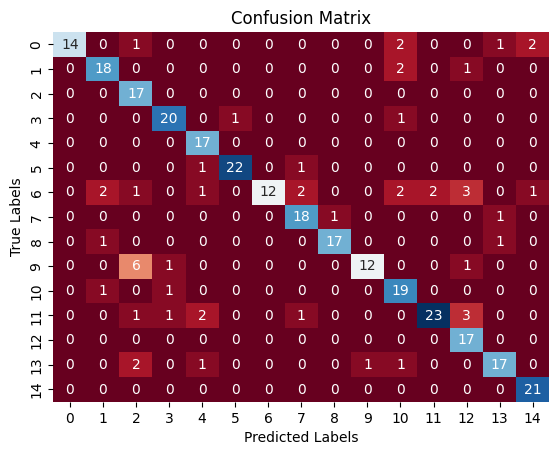

Accuracy is: 83.019%


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

image_data = '/kaggle/input/dangerous-insects-dataset/farm_insects'
pd.DataFrame(os.listdir(image_data), columns=['Files_Name'])

train_data_dir = image_data
batch_size = 32
target_size = (224, 224)
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names

plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False 

keras_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation=tf.nn.softmax)
])

tf.keras.utils.plot_model(keras_model, 
                          to_file='model_densenet121.png', 
                          show_shapes=True, 
                          show_layer_names=True, 
                          show_dtype=True, 
                          dpi=80)

keras_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

hist = keras_model.fit(train, epochs=10, validation_data=validation, callbacks=[early_stopping])

hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.show()

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))

df = pd.DataFrame()
df['Actual'], df['Prediction'] = y_val, y_pred

plt.figure(figsize=(25, 25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")
plt.show()

ax = plt.subplot()
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

acc = accuracy_score(y_val, y_pred)
print("Accuracy is: {0:.3f}%".format(acc * 100))
